# Imports

In [1]:
import sys, os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.ops import math_ops
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import layers
from tensorflow.keras import models
from ESN import EchoStateRNNCell
import csv
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
import IPython
from IPython.display import display, clear_output
#from IPython import display, get_ipython
#from IPython.display import display, Javascript

# memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# print a progres bar for the cell
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# random numbers
random_seed = np.frombuffer(os.urandom(4), dtype=np.uint32)[0]
print("seed: ", random_seed)

2024-01-23 02:21:44.971446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 02:21:46.368437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 02:21:46.368502: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 02:21:46.374848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 02:21:47.097773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 02:21:51.826368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

seed:  283802588


In [2]:
#Output Folder
notebook_name = "TOWNEPOD_ST_1.0Trunc_new_600_TTS_892"

# Automatically detect notebook name
output_folder = os.path.join(os.getcwd(), notebook_name + "_results")

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

In [3]:
#Controllable variables

lowFreq = 5
upperFreq = 500
duration_def= 1
#sampleRate = 10000
sampleRate = 10**5
numComponents = 50

#For defining ESN

inputScaling = 0.5
spectralRadius = 0.9
numUnits = 100
leakageRate = 0.2
decay_def = 0.1  # You can adjust the decay parameter

#For Training

epochs_def = 600

# The dataset generator

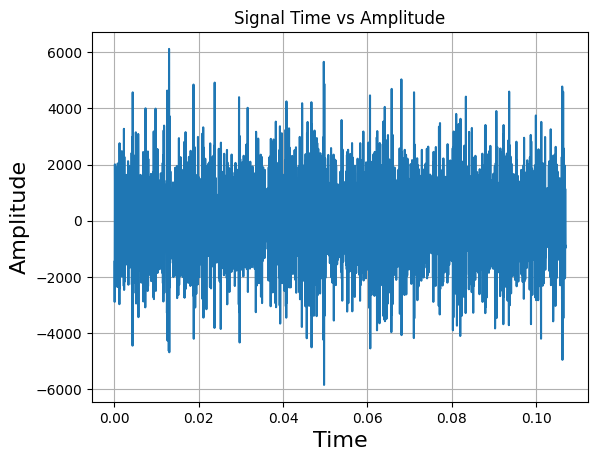

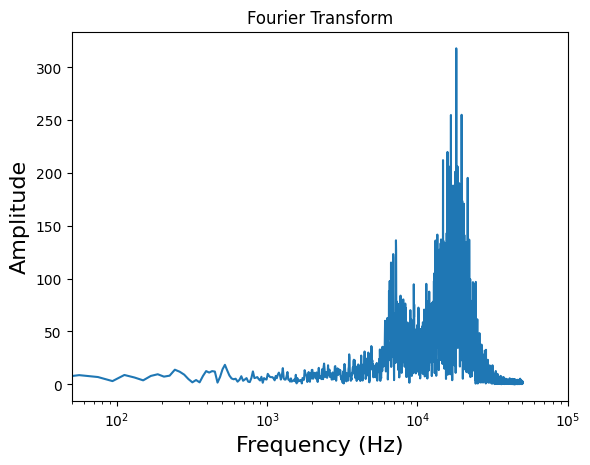

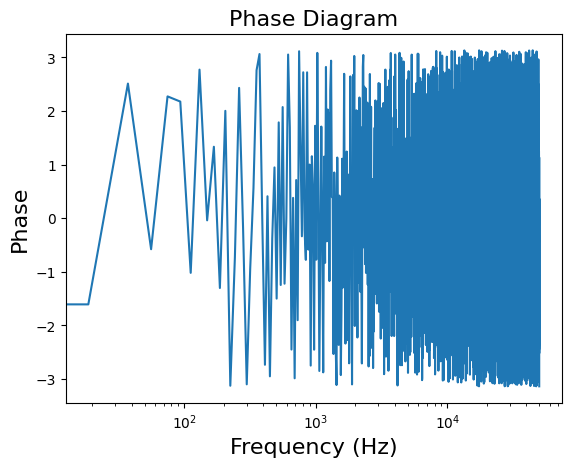

(None, None)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def fft_func(signal, sample_rate):

    if signal.shape[-1] == 1:
       signal = signal.squeeze(axis=-1)

    fft_result, fft_freq = matplotlib.mlab.complex_spectrum(signal, Fs=sample_rate,sides='onesided')
    return  2.0*fft_result, fft_freq
# Function to read CSV file and extract time and amplitude
def read_csv(file_path):
    times = []
    amplitudes = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            time, amplitude = map(float, row)
            times.append(time)
            amplitudes.append(amplitude)
    return np.array(times), np.array(amplitudes)

# Read data from CSV file
file_path = 'Towne_St_1_0.csv'  # Replace with the actual path to your CSV file
times, amplitudes = read_csv(file_path)

# Plot the signal
plt.plot(times, amplitudes)
plt.xlabel('Time', fontsize= 16)
plt.ylabel('Amplitude', fontsize= 16)
plt.title('Signal Time vs Amplitude')
plt.grid(True)
plt.savefig(os.path.join(output_folder, "Towne_SPOD_St_1_0_Original_Signal.png"), dpi=300, format='png'), plt.show()
    


# Compute Fourier transform of the truncated first mode
fft_result, fft_freq = fft_func(amplitudes, sample_rate= sampleRate)
plt.figure()
plt.semilogx(fft_freq, (np.abs(fft_result)))
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title('Fourier Transform')
# Set x-axis limits to cover the desired frequency range
plt.xlim(50, 100000)
plt.savefig(os.path.join(output_folder, "Towne_SPOD_St_1_0_Original_Signal_Fourier_Transform.png"), dpi=300, format='png'), plt.show()
real_part = np.real(fft_result)
imaginary_part = np.imag(fft_result)

# Compute the phase using np.arctan2
phase = np.arctan2(imaginary_part, real_part)

plt.figure()
plt.semilogx(fft_freq, phase)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel('Phase', fontsize=16)
plt.title('Phase Diagram', fontsize=16)
plt.savefig(os.path.join(output_folder, "Towne_SPOD_St_1_0_Phase.png"), dpi=300, format='png'), plt.show()


In [7]:
num_steps_for_training = 892
times_train = times[:num_steps_for_training]
amplitudes_train = amplitudes[:num_steps_for_training]

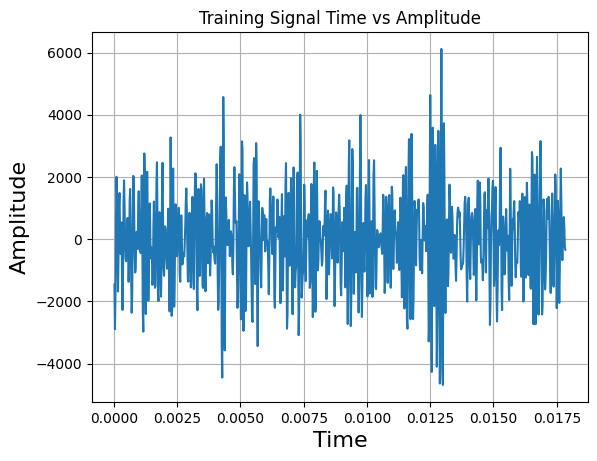

In [8]:
# Plot the signal for training data
plt.plot(times_train, amplitudes_train)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title('Training Signal Time vs Amplitude')
plt.grid(True)
plt.savefig(os.path.join(output_folder, "Training_Signal.png"), dpi=300, format='png')
plt.show()

# 0.3. Define ESN

In [9]:
class EchoStateRNNCell(layers.Layer):
    def __init__(self, units, activation, epsilon, alpha, optimize, optimize_vars, seed,
                 input_scaling, spectral_radius, leakage_rate, decay):
        super(EchoStateRNNCell, self).__init__()
        self.units = units
        self.activation = activation
        self.epsilon = epsilon
        self.alpha = alpha
        self.optimize = optimize
        self.optimize_vars = optimize_vars
        self.seed = seed
        self.input_scaling = input_scaling
        self.spectral_radius = spectral_radius
        self.leakage_rate = leakage_rate
        self.decay = decay  # Add the decay parameter

        # Specify the state_size attribute as a tuple
        self.state_size = (self.units,)

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Initialize your cell parameters here
        self.kernel = self.add_weight("kernel",
                                      shape=(input_dim + self.units, self.units),
                                      initializer="glorot_uniform",
                                      trainable=True)
        self.recurrent_kernel = self.add_weight("recurrent_kernel",
                                                shape=(self.units, self.units),
                                                initializer="orthogonal",
                                                trainable=True)

        # Scale the recurrent weights to achieve the desired spectral radius
        self.recurrent_kernel = self.spectral_radius * self.recurrent_kernel / max(np.linalg.norm(self.recurrent_kernel), 1)

    def call(self, inputs, states):
        prev_output = states[0]

        # Your cell logic goes here
        new_output = (1 - self.leakage_rate - self.decay) * prev_output + self.leakage_rate * self.activation(
            tf.matmul(tf.concat([inputs, prev_output], axis=-1), self.kernel) +
            tf.matmul(prev_output, self.recurrent_kernel)
        )

        return new_output, [new_output]

    def get_config(self):
        return {
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation),
            "epsilon": self.epsilon,
            "alpha": self.alpha,
            "optimize": self.optimize,
            "optimize_vars": self.optimize_vars,
            "seed": self.seed,
            "input_scaling": self.input_scaling,
            "spectral_radius": self.spectral_radius,
            "leakage_rate": self.leakage_rate,
            "decay": self.decay
        }

# Input data Preprocessing

In [10]:
entire_data = np.column_stack((times, amplitudes))
entire_data_amplitudes_only = entire_data[:, 1]
entire_data_amplitudes_only_normalized = entire_data_amplitudes_only / 100000.0


input_data = np.column_stack((times_train, amplitudes_train))
#rnn_inputs = input_data.reshape(1, -1, 2)
#rnn_targets = np.roll(input_data, -1).reshape(1, -1, 2)

amplitudes_only = input_data[:, 1]
amplitudes_only_normalized = amplitudes_only / 100000.0



# 0.4 Reshape the input data

In [11]:
# Reshape the input data
rnn_inputs = amplitudes_only_normalized.reshape(1, -1, 1)
rnn_targets = np.roll(amplitudes_only_normalized, -1).reshape(1, -1, 1)  # Shift targets by 1 time step



#rnn_inputs = input_data.reshape(1, -1, 1)
#rnn_targets = np.roll(input_data, -1).reshape(1, -1, 1)  # Shift targets by 1 time step

# 0.5 Initialize the ESN and set parameters for ESN

In [12]:
# Set parameters for the ESN
input_scaling = inputScaling
spectral_radius = spectralRadius
num_units = numUnits
leakage_rate = leakageRate
decay = decay_def  # You can adjust the decay parameter

# Create an instance of EchoStateRNNCell
echo_state_rnn_cell = EchoStateRNNCell(units=num_units,
                                       activation=tf.keras.activations.tanh,
                                       epsilon=1e-20,
                                       alpha=0.5,
                                       optimize=True,
                                       optimize_vars=["rho", "decay", "alpha", "sw"],
                                       seed=42,
                                       input_scaling=input_scaling,
                                       spectral_radius=spectral_radius,
                                       leakage_rate=leakage_rate,
                                       decay=decay)

# Build the recurrent layer
recurrent_layer = layers.RNN(echo_state_rnn_cell, input_shape=(None, 1),
                             return_sequences=True, name="esn_rnn")

# Build the output layer
output_layer = layers.Dense(1, name="readouts")

# Compile the model
model = models.Sequential()
model.add(recurrent_layer)
model.add(output_layer)
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 esn_rnn (RNN)               (None, None, 100)         10100     
                                                                 
 readouts (Dense)            (None, None, 1)           101       
                                                                 
Total params: 10201 (39.85 KB)
Trainable params: 10201 (39.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 0.6 Training

In [13]:
%reload_ext tensorboard

In [14]:
tensorboard --logdir=tensorboard

In [15]:
logdir="tensorboard"

In [16]:
summary_writer = tf.summary.create_file_writer(logdir)

1/1 [==============================] - 1s 620ms/step


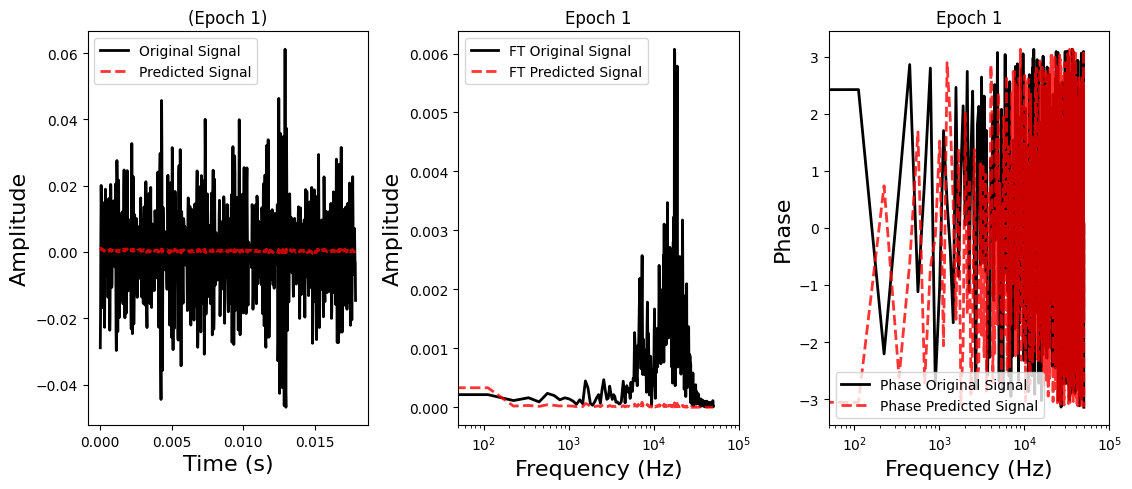

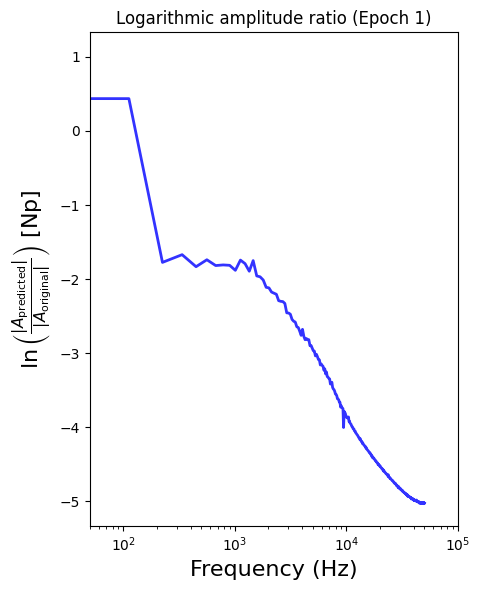

1/1 [==============================] - 1s 1s/step


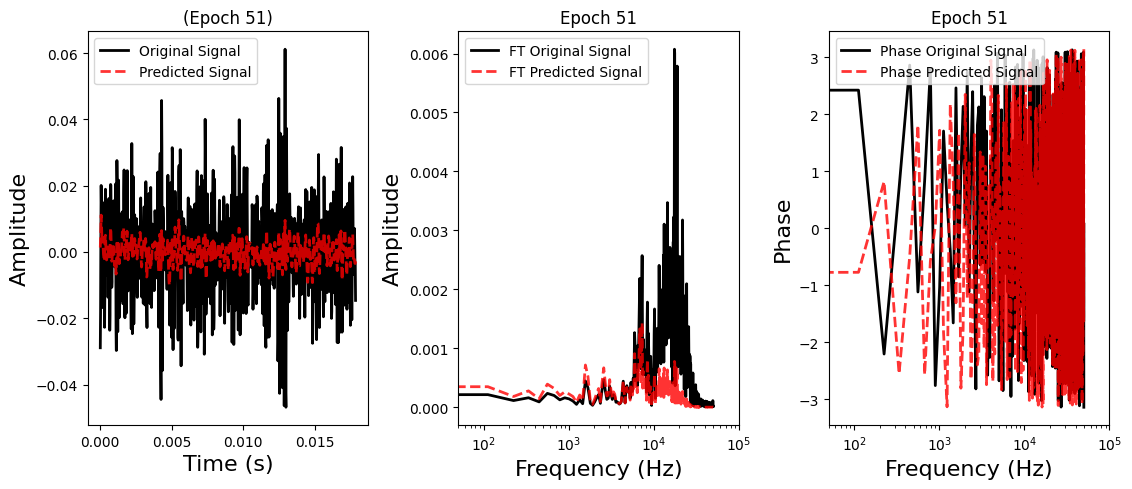

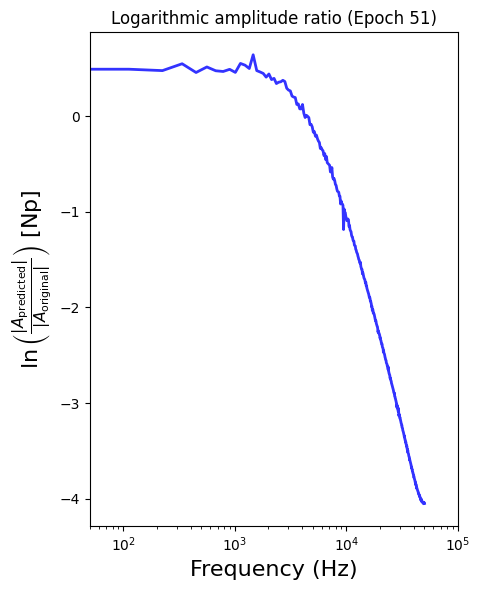

1/1 [==============================] - 0s 43ms/step


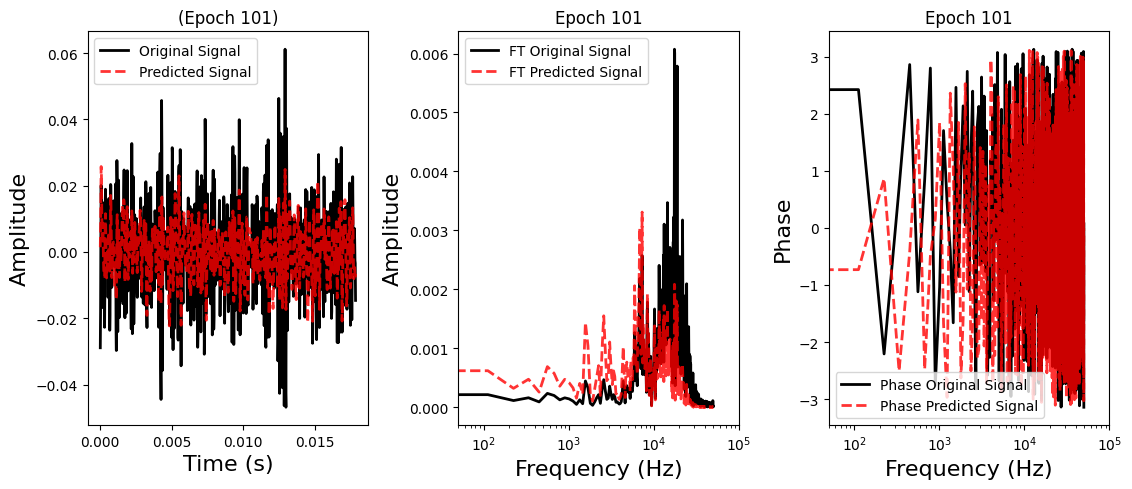

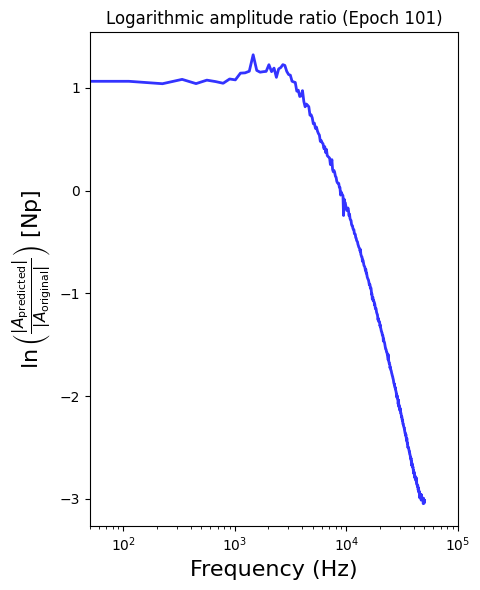

1/1 [==============================] - 0s 43ms/step


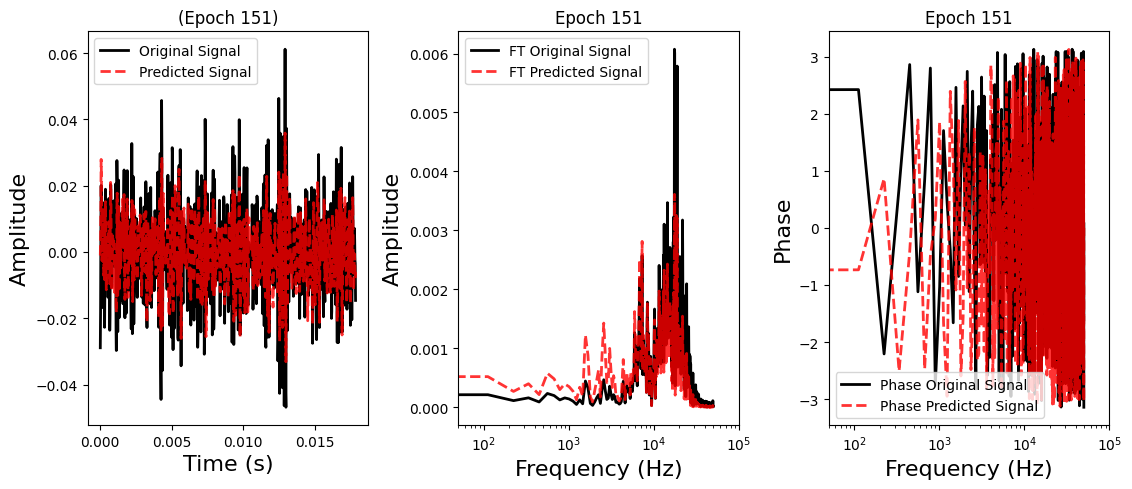

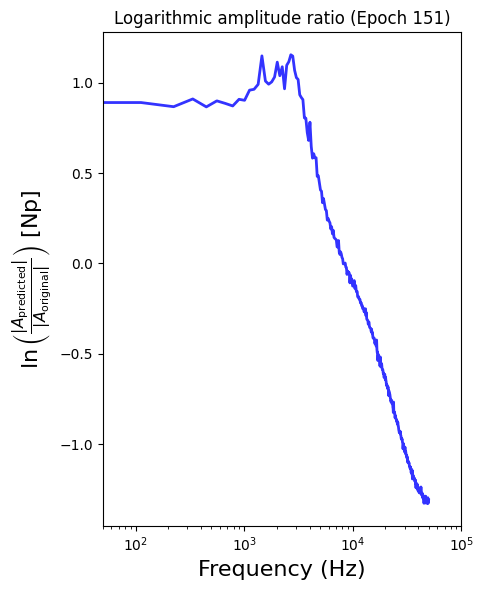

1/1 [==============================] - 0s 46ms/step


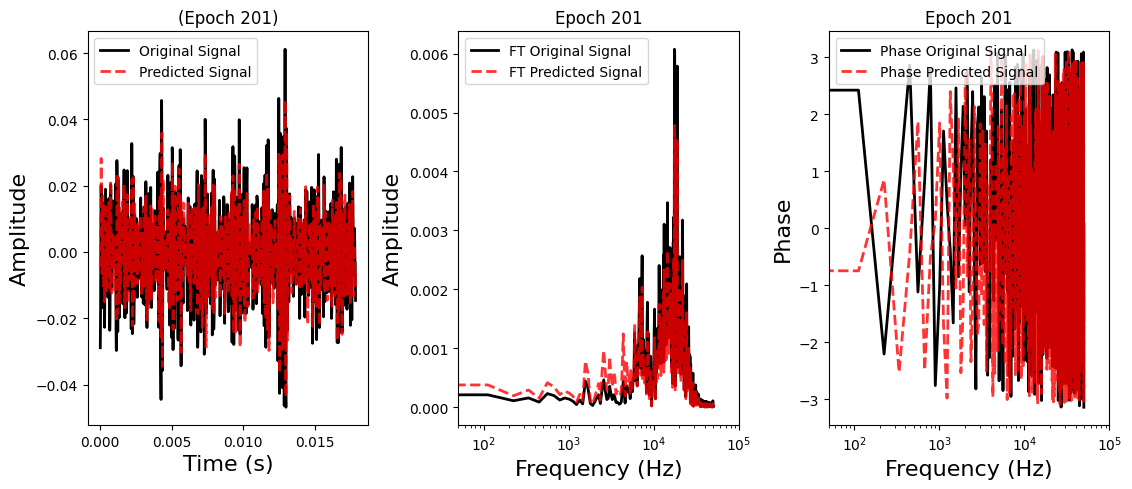

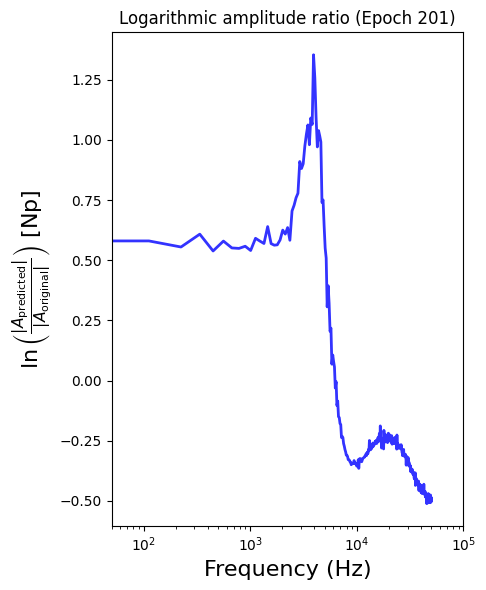

1/1 [==============================] - 0s 43ms/step


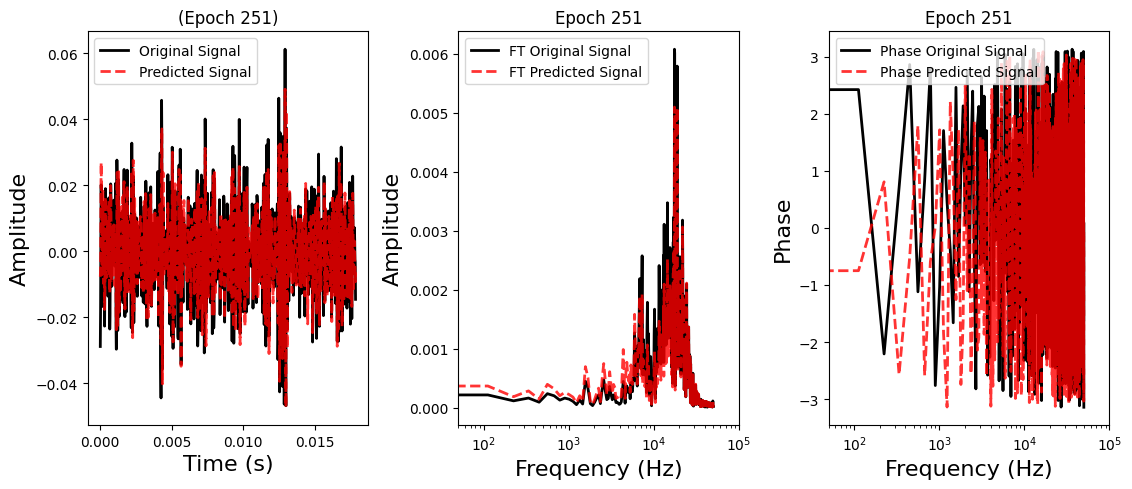

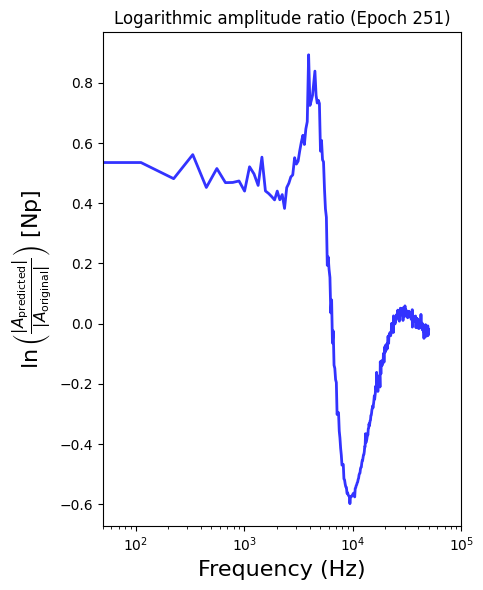

1/1 [==============================] - 0s 42ms/step


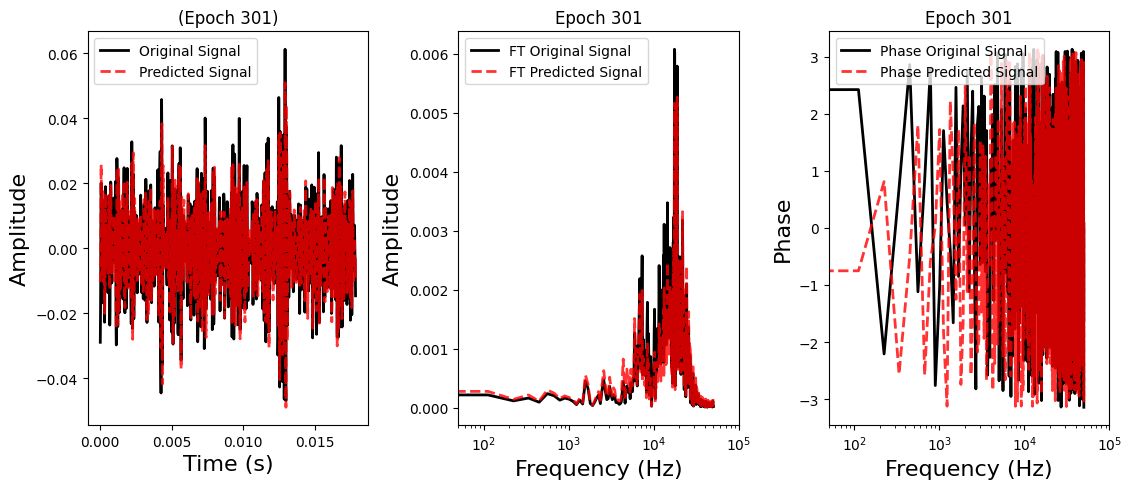

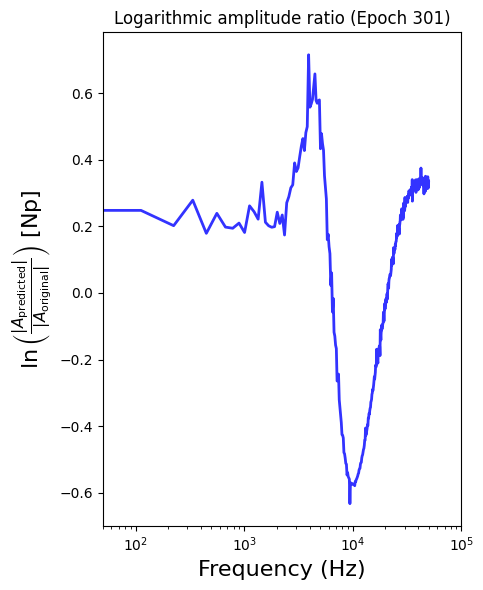

1/1 [==============================] - 0s 49ms/step


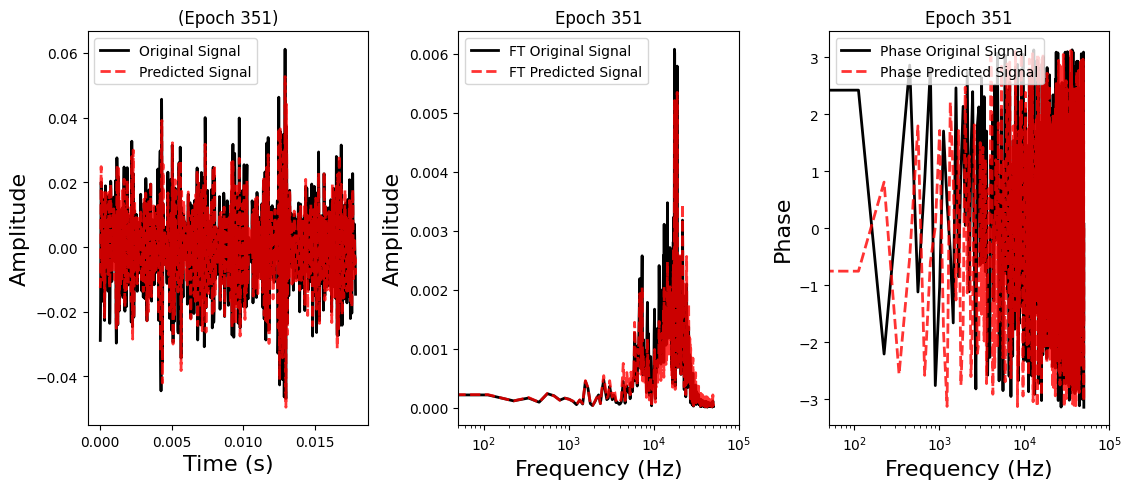

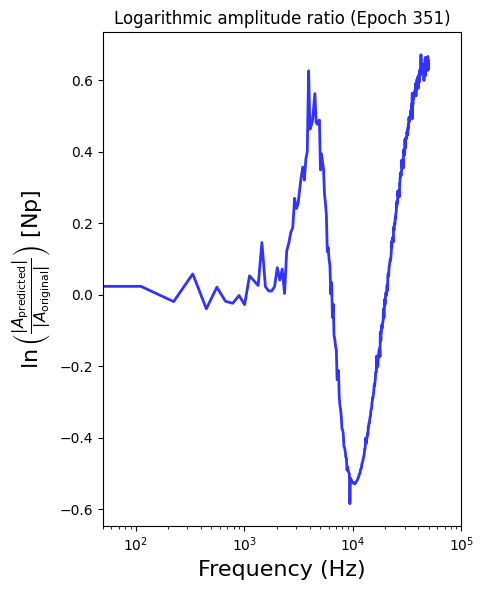

1/1 [==============================] - 0s 49ms/step


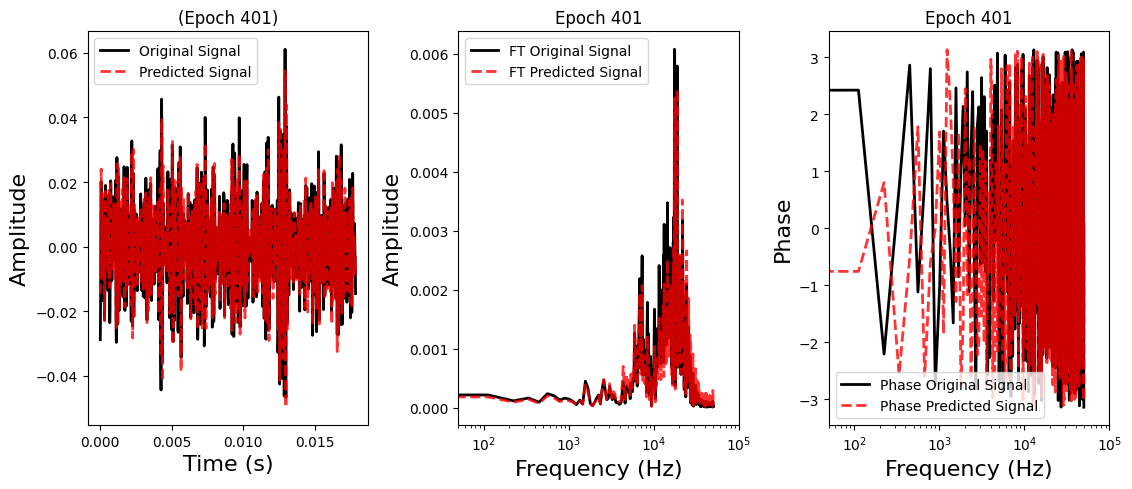

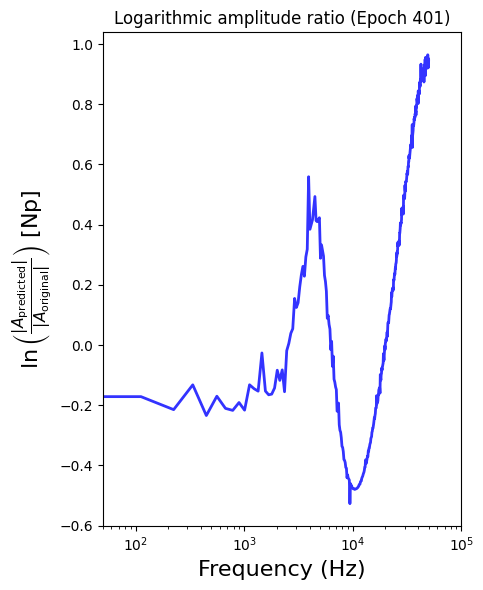

1/1 [==============================] - 0s 45ms/step


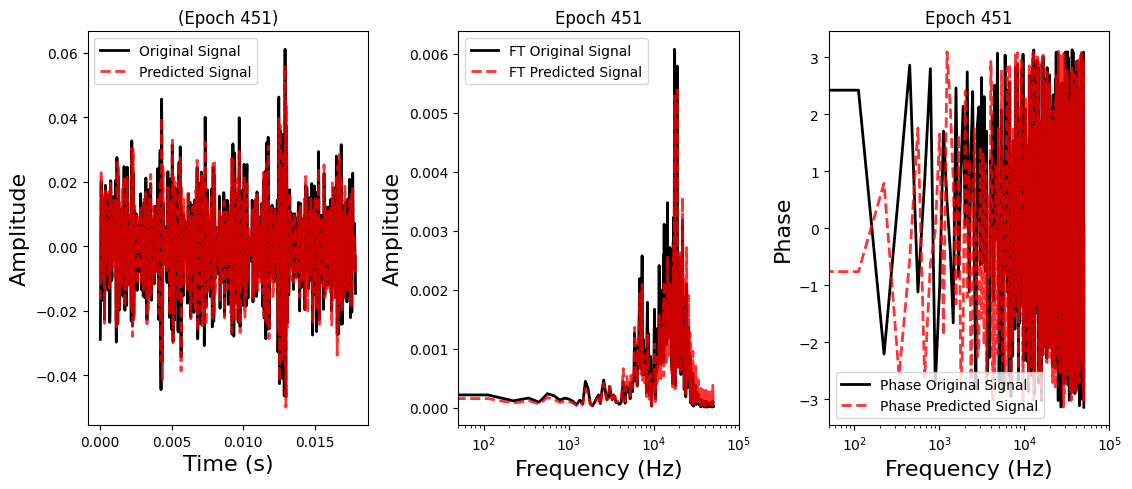

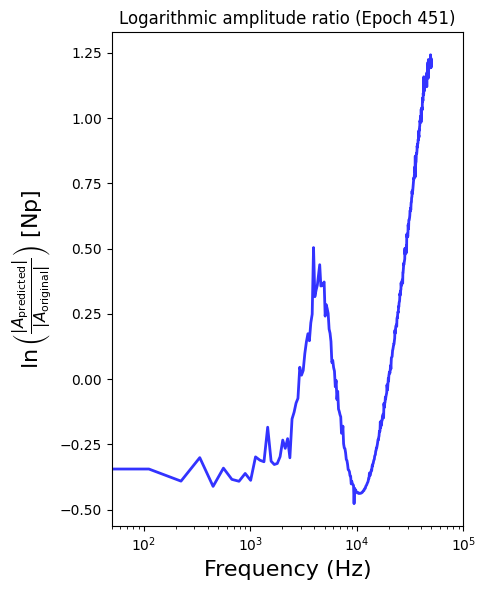

1/1 [==============================] - 0s 47ms/step


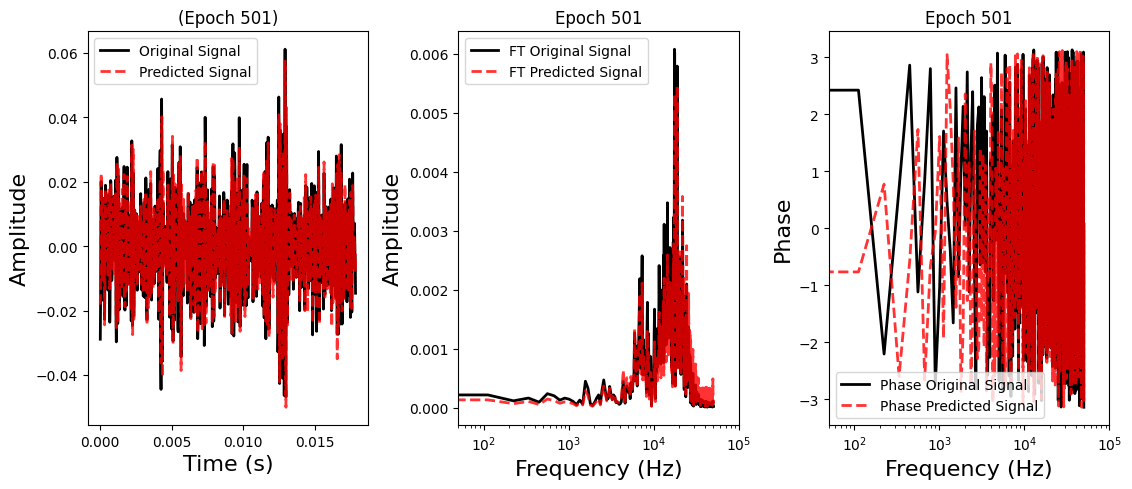

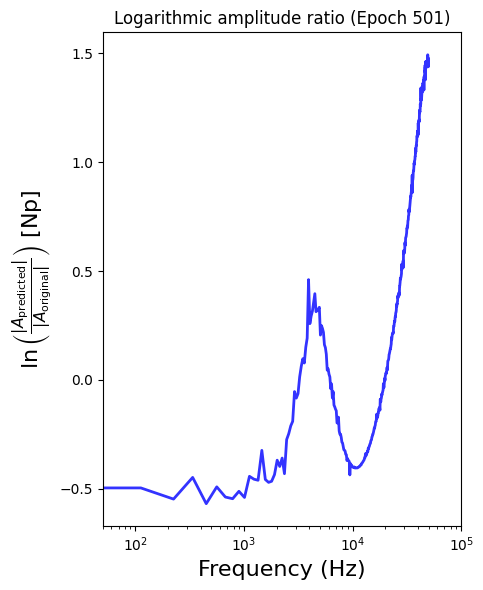

1/1 [==============================] - 0s 64ms/step


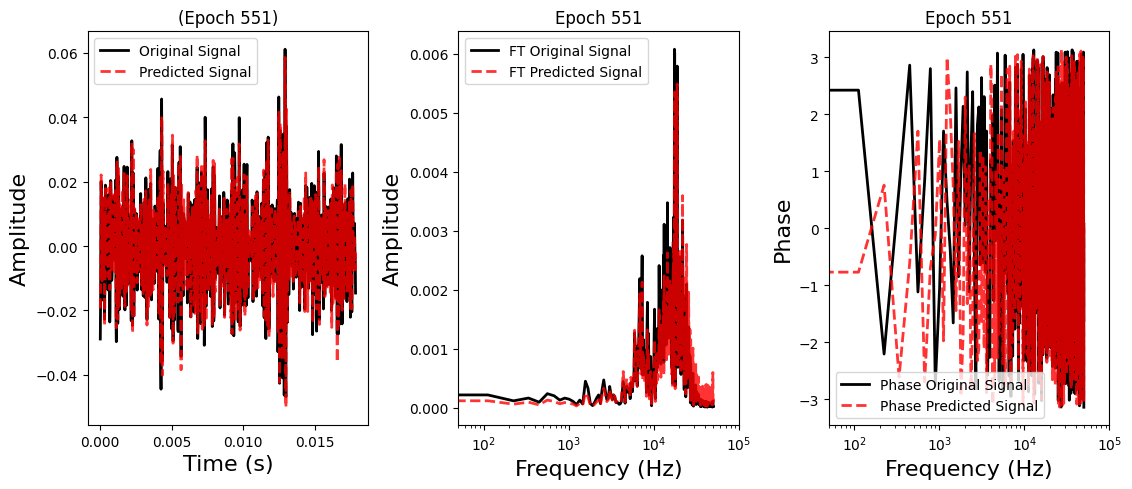

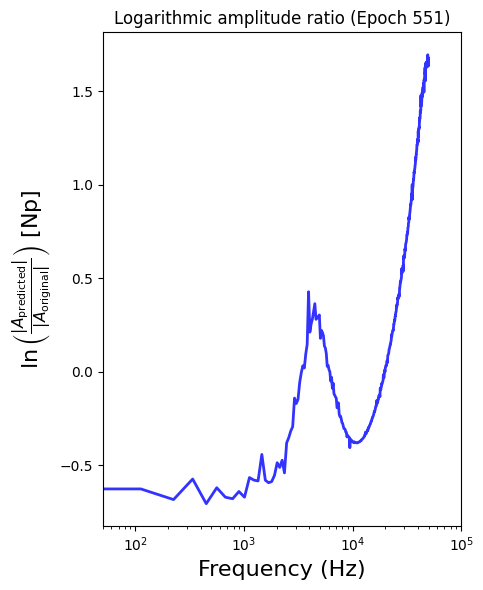

In [17]:
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(15, 5))
#ax4 = fig.add_subplot(144)
rmse_losses = []
# Assuming you have an ESN model and training data (rnn_inputs, rnn_targets) defined
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

epochs = epochs_def # Adjust the number of epochs as needed
losses = np.zeros(epochs)

out = display(progress(0, epochs), display_id=True)

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = model(rnn_inputs)  # Replace 'model' with your ESN model
        current_loss = tf.reduce_mean(tf.square(outputs - rnn_targets))

    grads = tape.gradient(current_loss, model.trainable_variables) 
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    losses[epoch] = current_loss.numpy()
    rmse_losses.append(np.sqrt(current_loss.numpy()))
    # Log the loss to TensorBoard
    if epoch%50==0:
        with summary_writer.as_default():
            tf.summary.scalar('loss', current_loss, step=epoch)
    
        # Show the original and predicted signals vs. original input signal after each epoch
        predicted_signal = model.predict(rnn_inputs)  # Replace with your ESN prediction method
        
        # Plot the original and predicted signals
        plt.figure(figsize=(15, 5))
        
        plt.subplot(141)
        plt.plot(times_train, rnn_targets[0], label='Original Signal', color='black', linewidth=2)
        plt.plot(times_train, predicted_signal[0], label='Predicted Signal', color='red', linestyle='dashed', linewidth=2, alpha=0.8)
        plt.xlabel('Time (s)', fontsize=16)
        plt.ylabel('Amplitude', fontsize=16)
        plt.title('(Epoch {})'.format(epoch + 1))
        plt.legend()
        # Save the signal plot
        signal_plot_name = f"Towne_SPOD_Signal_Training_epoch_{epoch + 1}_St_1_0.png"
        signal_plot_path = os.path.join(output_folder, signal_plot_name)
        plt.savefig(signal_plot_path, dpi=300, format='png')
    
        # Plot the Fourier Transform of the original and predicted signals
        fft_original, fft_freq_original = fft_func(rnn_targets[0].squeeze(), sampleRate) # declare this sampling freq variable in the beginning
        #fft_original, fft_freq_original = fft_func(first_mode, sampleRate)
        fft_predicted, fft_freq_predicted = fft_func(predicted_signal[0].squeeze(), sampleRate) 
    
        plt.subplot(142)
        plt.semilogx(fft_freq_original, (np.abs(fft_original)), label='FT Original Signal', color='black', linewidth=2)
        plt.semilogx(fft_freq_predicted, (np.abs(fft_predicted)), label='FT Predicted Signal', color='red', linestyle='dashed', linewidth=2, alpha=0.8)
        plt.xlabel('Frequency (Hz)', fontsize=16)
        plt.ylabel('Amplitude', fontsize=16)
        plt.xlim([50, 100000])
        plt.title('Epoch {}'.format(epoch + 1))
        plt.legend()
        ft_plot_name = f"Towne_SPOD_FT_Training_epoch_{epoch + 1}_St_1_0.png"
        ft_plot_path = os.path.join(output_folder, ft_plot_name)
        plt.savefig(ft_plot_path, dpi=300, format='png')
        # Calculate the ratio of amplitudes for each frequency and take the log
        amplitude_ratio = np.log( (np.abs(fft_predicted)) / (np.abs(fft_original)))


        #plotting phase
        plt.subplot(143)
        plt.semilogx(fft_freq_original, np.angle(fft_original), label='Phase Original Signal', color='black', linewidth=2)
        plt.semilogx(fft_freq_predicted, np.angle(fft_predicted), label='Phase Predicted Signal', color='red', linestyle='dashed', linewidth=2, alpha=0.8)
        plt.xlabel('Frequency (Hz)', fontsize=16)
        plt.ylabel('Phase', fontsize=16)
        plt.xlim([50, 100000])
        plt.title('Epoch {}'.format(epoch + 1))
        plt.legend()
    
        plt.tight_layout()
        plt.show()

        # Plot the log ratio of amplitudes
        plt.figure(figsize=(18, 6))
        plt.subplot(144)
        plt.semilogx(fft_freq_original, amplitude_ratio, label='Log(Amplitude Prediction / Amplitude Original)', color='blue', linewidth=2, alpha=0.8)
        plt.xlabel('Frequency (Hz)', fontsize=16)
        plt.ylabel(r'$\ln\left(\frac{|A_{\text{predicted}}|}{|A_{\text{original}}|}\right)$ [Np]', fontsize=16)
        plt.xlim([50,100000])
        plt.title('Logarithmic amplitude ratio (Epoch {})'.format(epoch + 1))
        # Save the Logarithmic amplitude ratio plot
        ln_ratio_plot_name = f"ln_ratio_Training_epoch_{epoch + 1}_St_1_0.png"
        ln_ratio_plot_path = os.path.join(output_folder, ln_ratio_plot_name)
        plt.savefig(ln_ratio_plot_path, dpi=300, format='png')
        #plt.close()
        #plt.legend()

        plt.tight_layout()
        plt.show()
        
    # Update the progress bar
    out.update(progress(epoch + 1, epochs))

# Close the TensorBoard summary writer
summary_writer.close()

In [18]:
np.savetxt('rmse_losses.txt_0T', rmse_losses, delimiter=',')

In [19]:
rnn_targets[0].shape

(892, 1)

# 0.7 Loss curve

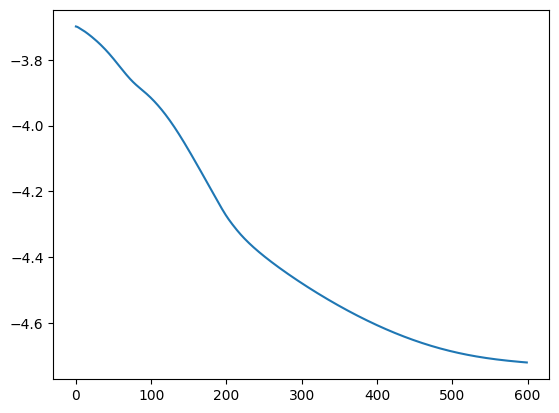

In [20]:
p = plt.plot(np.log10(losses))
plt.show()

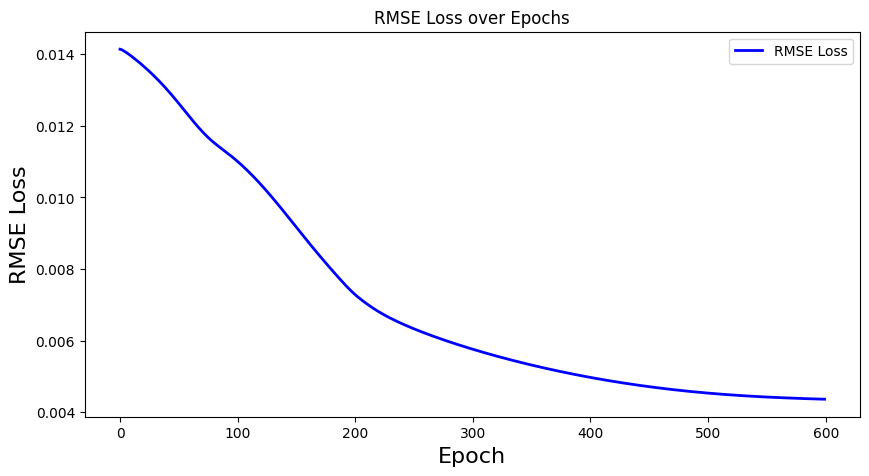

In [21]:
# Plot RMSE for each epoch
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), rmse_losses, label='RMSE Loss', color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('RMSE Loss', fontsize=16)
plt.title('RMSE Loss over Epochs')
plt.legend()
plt.show()


# 0.8 Predicted Model vs Trained Model

1/1 [==============================] - 1s 818ms/step


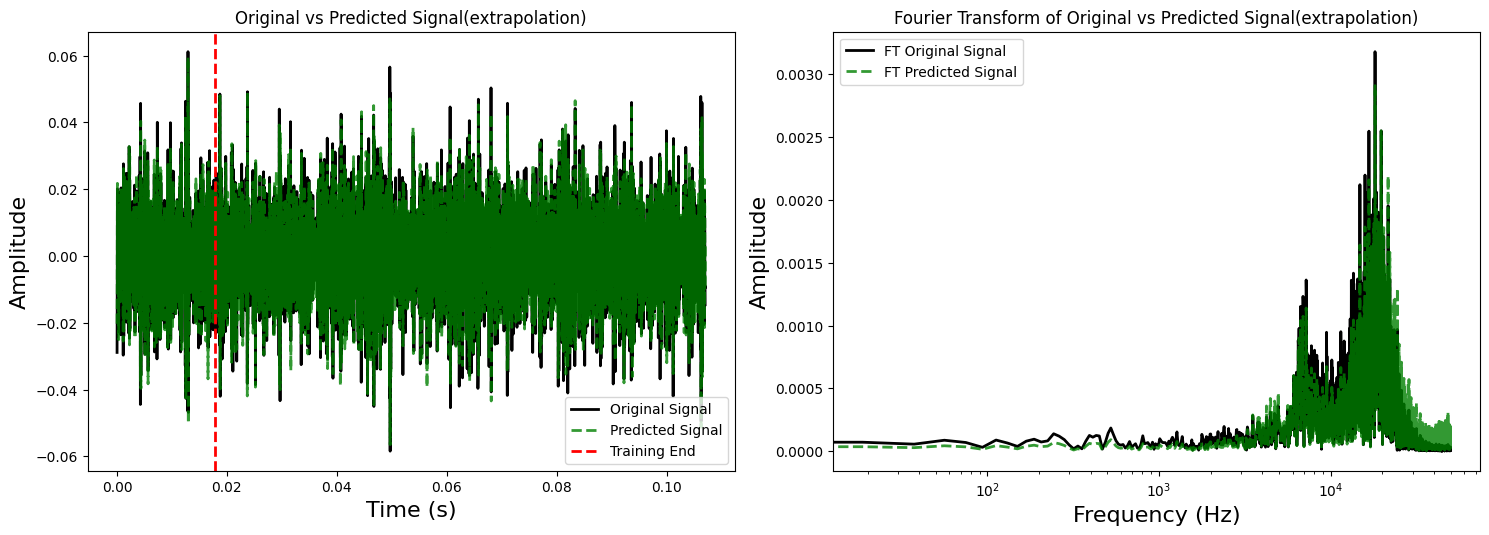

(None, None)

In [22]:

# Reshape and preprocess the new signal for input to the ESN model

new_rnn_inputs = entire_data_amplitudes_only_normalized .reshape(1, -1, 1)
new_rnn_targets = np.roll(entire_data_amplitudes_only_normalized , -1).reshape(1, -1, 1)  # Shift targets by 1 time step

# Use the trained ESN model to make predictions on the new signal
predicted_new_signal = model.predict(new_rnn_inputs)

# Plot both original vs predicted signals and their Fourier Transforms in a single plot
plt.figure(figsize=(15, 10))

# Plot the original and predicted signals
plt.subplot(221)
plt.plot(times, new_rnn_targets[0], label='Original Signal', color ='black', linewidth=2)
plt.plot(times, predicted_new_signal[0], label='Predicted Signal', color='green',linestyle='dashed', linewidth=2, alpha=0.8)
plt.axvline(x=times[num_steps_for_training], color='red', linestyle='dashed', linewidth=2, label='Training End')
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title('Original vs Predicted Signal(extrapolation)')
plt.legend()

# Plot the Fourier Transform of the original and predicted signals

fft_original_test, fft_freq_original_test = fft_func(new_rnn_targets[0].squeeze(), sample_rate=sampleRate)
fft_predicted_test, fft_freq_predicted_test = fft_func(predicted_new_signal[0].squeeze(), sample_rate=sampleRate)

plt.subplot(222)
plt.semilogx(fft_freq_original_test, (np.abs(fft_original_test)), label='FT Original Signal', color ='black', linewidth=2)
plt.semilogx(fft_freq_predicted_test, (np.abs(fft_predicted_test)), label='FT Predicted Signal', color='green',linestyle='dashed', linewidth=2, alpha=0.8)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title('Fourier Transform of Original vs Predicted Signal(extrapolation)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Towne_SPOD_St_1_0_Extrapolation.png"), dpi=300, format='png'), plt.show()